# Image Segmentation with Mask R-CNN

## Downloading the repository

In [2]:
!git clone https://github.com/alsombra/Mask_RCNN-TF2  

Cloning into 'Mask_RCNN-TF2'...
Updating files:  86% (66/76)
Updating files:  88% (67/76)
Updating files:  89% (68/76)
Updating files:  90% (69/76)
Updating files:  92% (70/76)
Updating files:  93% (71/76)
Updating files:  94% (72/76)
Updating files:  96% (73/76)
Updating files:  97% (74/76)
Updating files:  98% (75/76)
Updating files: 100% (76/76)
Updating files: 100% (76/76), done.


In [3]:
%cd Mask_RCNN-TF2

In [ ]:
!pip install -r requirements.txt

In [2]:
!python setup.py install

In [4]:
%cd ..

## Importing the libraries

In [8]:
import os
import sys
import cv2
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

In [9]:
import tensorflow as tf

In [10]:
tf.__version__

'2.12.0'

In [ ]:
ROOT_DIR = os.path.abspath('./Mask_RCNN-TF2')

In [ ]:
sys.path

In [13]:
sys.path.append(ROOT_DIR)

In [ ]:
sys.path

In [15]:
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib

In [16]:
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))

In [8]:
sys.path

In [20]:
import coco

In [21]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')

## Loading the pre-trained neural network

In [24]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')

In [25]:
utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [26]:
class InferenceConfig(coco.CocoConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

In [27]:
config = InferenceConfig()

In [28]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [30]:
network = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=config)

Instructions for updating:
Use fn_output_signature instead


In [31]:
network.load_weights(COCO_MODEL_PATH, by_name=True)

## Detecting objects

In [32]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [33]:
len(class_names)

81

In [34]:
class_names[1], class_names.index('person')

('person', 1)

In [42]:
image = skimage.io.imread('dog.jpg') # RGB

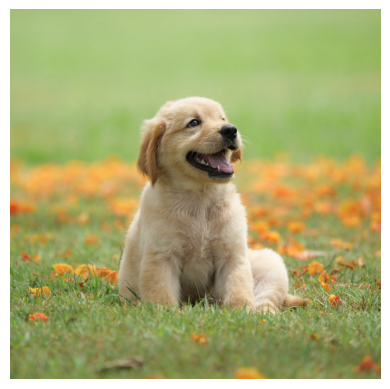

In [44]:
plt.imshow(image);
plt.axis('off')
plt.show()

In [45]:
class_names[17], class_names[1], class_names[14]

('dog', 'person', 'bench')

In [ ]:
results = network.detect([image], verbose=0)
results

In [47]:
r = results[0]

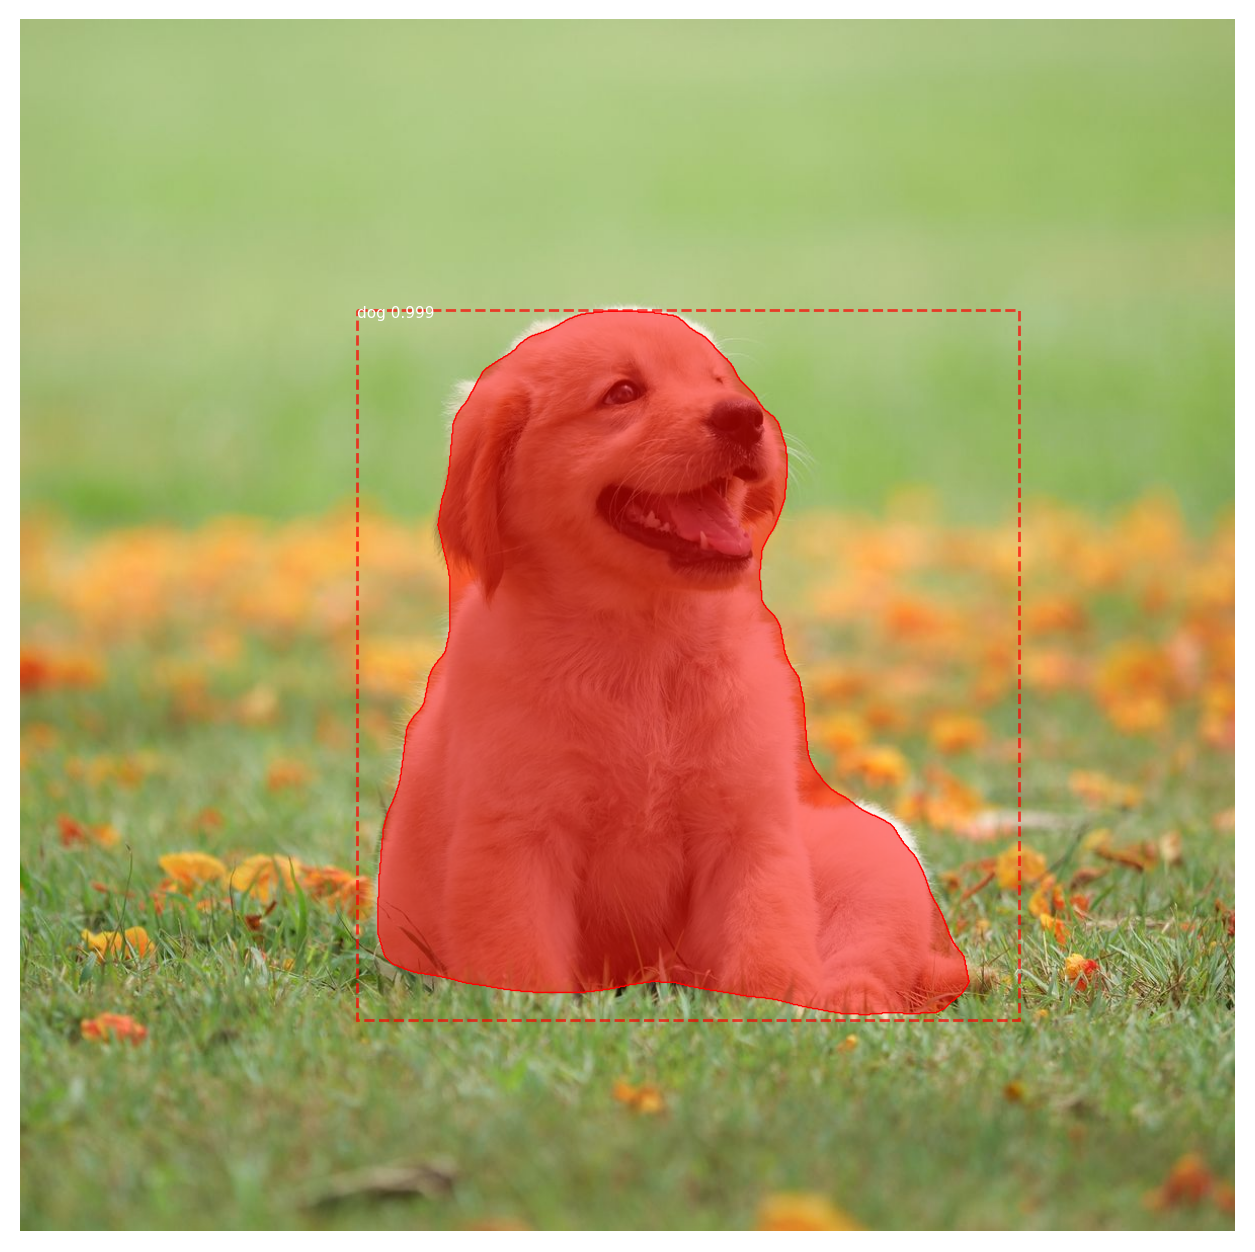

In [48]:
visualize.display_instances(image, r['rois'], r['masks'],
                            r['class_ids'], class_names, r['scores'])

## Removing the background

In [49]:
np.unique(r['masks'], return_counts=True)

(array([False,  True]), array([1178161,  258239], dtype=int64))

In [50]:
r['masks']

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

In [51]:
def segment(image, r, index):
  mask = r['masks'][:,:,index]
  #print(mask)
  #print(mask.shape)

  mask = np.stack((mask,) * 3, axis = -1)
  #print(mask)
  #print(mask.shape)

  mask = mask.astype('uint8')
  #print(mask)
  bg = 255 - mask * 255
  #print(mask, mask.min(), mask.max())

  mask_show = np.invert(bg)
  #print(mask_show)
  mask_img = image * mask
  #print(mask_img)

  result = mask_img + bg
  return result, mask_show

In [52]:
image.shape, 425 * 640

((1197, 1200, 3), 272000)

In [53]:
segmentation, mask_obj = segment(image, r, 0)

In [54]:
segmentation

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [55]:
mask_obj

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [56]:
def show_segment(image, r, index, show_mask = False):
  segmentation, mask_obj = segment(image, r, index)
  plt.subplots(1, figsize=(16,16))
  plt.axis('off')
  if show_mask == True:
    plt.imshow(np.concatenate([mask_obj, segmentation], axis = 1))
  else:
    plt.imshow(np.concatenate([image, segmentation], axis = 1))

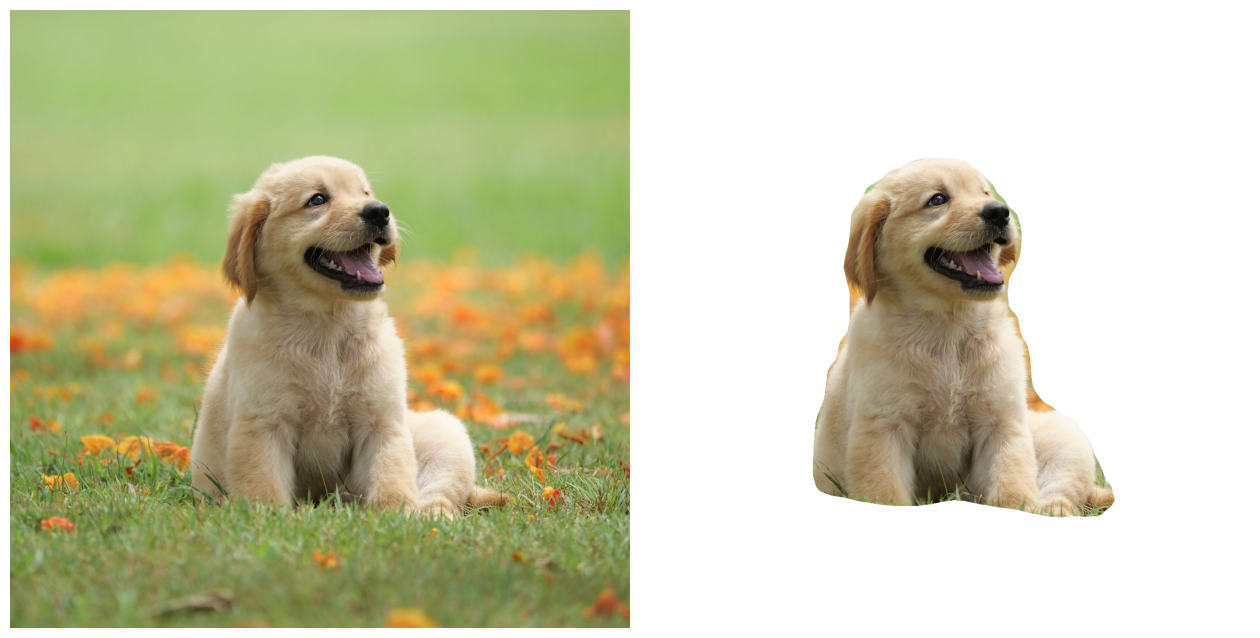

In [57]:
show_segment(image, r, 0, False)

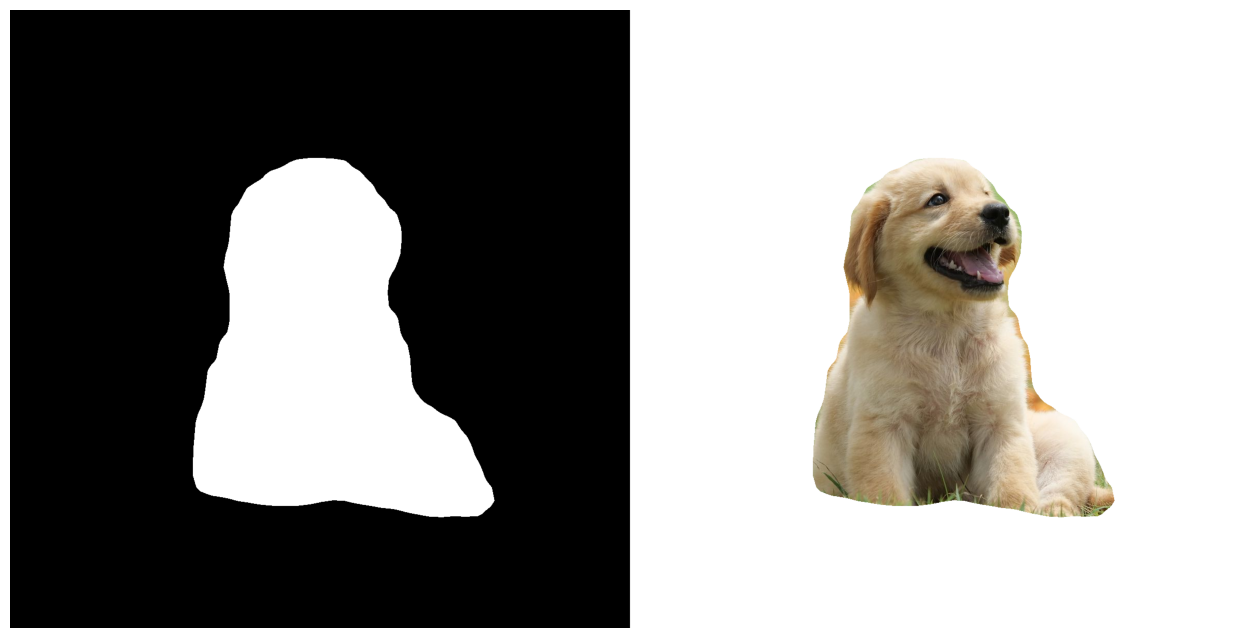

In [58]:
show_segment(image, r, 0, True)

In [59]:
r['rois'], len(r['rois'])

(array([[286, 333, 988, 987]]), 1)